1. 时序模型中，当前数据跟之前观察到的数据相关
2. 自回归模型使用自身过去数据来预测未来
3. 马尔可夫模型假设当前只跟最近少数数据相关，从而简化模型
4. 潜变量模型使用潜变量来概括历史信息

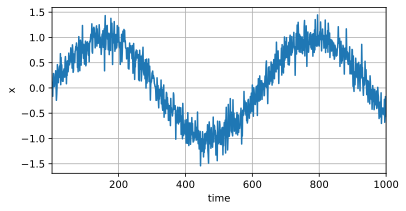

In [22]:
import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6,3))

In [23]:
# 使用马尔可夫假设

# 只跟前4步有关
tau = 4

features = torch.zeros((T-tau, tau)) # torch.Size([996, 4])
for i in range(tau):
    features[:,i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))
labels.shape

torch.Size([996, 1])

In [24]:
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

In [25]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)

# 这里就实现一个简单的多层感知机
def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
        )
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction='none')

In [26]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch+1}, loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.054137
epoch 2, loss: 0.047392
epoch 3, loss: 0.048702
epoch 4, loss: 0.049733
epoch 5, loss: 0.045958


In [27]:
# 模型预测下一个时间步

onestep_preds = net(features)
onestep_preds.shape

torch.Size([996, 1])

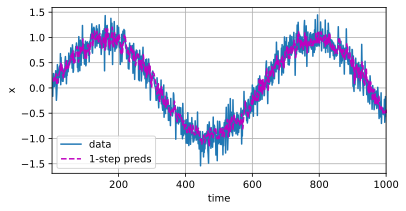

In [28]:
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6,3)) 

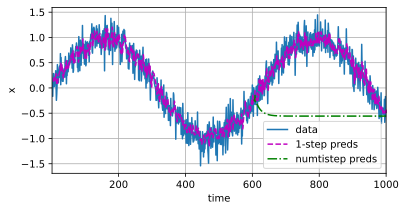

In [29]:
# 测试多步预测

multistep_preds = torch.zeros(T)
multistep_preds[:n_train+tau] = x[:n_train+tau] # 前面训练的数据，直接复制过来

for i in range(n_train+tau, T):
    multistep_preds[i] = net(multistep_preds[i-tau:i].reshape((1, -1)))


d2l.plot([time, time[tau:],time[n_train+tau:]], [x.detach().numpy(), onestep_preds.detach().numpy(), multistep_preds[n_train+tau:].detach().numpy()], 'time', 'x', legend=['data', '1-step preds','numtistep preds'], xlim=[1, 1000], figsize=(6,3)) 

In [30]:
max_steps = 64

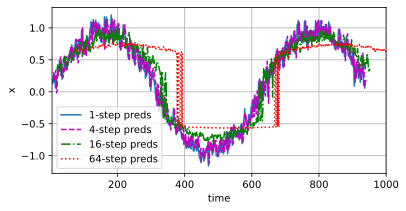

In [46]:
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
for i in range(tau):
    features[:, i] = x[i: i+ T - tau - max_steps + 1]

for i in range(tau, tau+max_steps):
    features[:,i] = net(features[:, i-tau:i]).reshape(-1)


steps = (1, 4, 16, 64)
d2l.plot([time[tau+i-1: T-max_steps+i] for i in steps], [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x', legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000], figsize=(6, 3))

In [33]:
(T - tau - max_steps + 1, tau + max_steps), x.shape

((933, 68), torch.Size([1000]))

In [36]:
features[0], x[:10]

(tensor([ 0.1123,  0.0193, -0.1646,  0.1977,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000]),
 tensor([ 0.1123,  0.0193, -0.1646,  0.1977,  0.2858,  0.2797,  0.0262,  0.0303,
          0.1519,  0.1358]))

In [41]:

print(time[tau+1-4: T-max_steps+4])

tensor([  5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,
         17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,
         29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,
         41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,
         53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,
         65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
         89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.,
        101., 102., 103., 104., 105., 106., 107., 108., 109., 110., 111., 112.,
        113., 114., 115., 116., 117., 118., 119., 120., 121., 122., 123., 124.,
        125., 126., 127., 128., 129., 130., 131., 132., 133., 134., 135., 136.,
        137., 138., 139., 140., 141., 142., 143., 144., 145., 146., 147., 148.,
        149., 150., 151., 152., 153., 15

In [43]:
print(time[tau+4-1: T-max_steps+4])

tensor([  8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,
         20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,
         32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
         56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,
         68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,
         80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,
         92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103.,
        104., 105., 106., 107., 108., 109., 110., 111., 112., 113., 114., 115.,
        116., 117., 118., 119., 120., 121., 122., 123., 124., 125., 126., 127.,
        128., 129., 130., 131., 132., 133., 134., 135., 136., 137., 138., 139.,
        140., 141., 142., 143., 144., 145., 146., 147., 148., 149., 150., 151.,
        152., 153., 154., 155., 156., 15